In [20]:
import os
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import warnings
warnings.filterwarnings("ignore")

if not os.path.isdir("notebooks"):
    os.chdir("..")
from plots._helpers import (load_ember_data, create_results_dir, 
                                    load_pypsa_network, get_demand_ember, 
                                    get_demand_pypsa, get_installed_capacity_ember, 
                                    get_installed_capacity_pypsa, get_generation_capacity_ember, 
                                    get_generation_capacity_pypsa, get_data_EIA, preprocess_eia_data, 
                                    preprocess_eia_data_generation, get_generation_capacity_pypsa_detail, 
                                    get_generation_capacity_ember_detail, convert_two_country_code_to_three)

In [21]:
# Choose the country and the horizon for validation
# Country code should be in ISO 3166-1 alpha-2 format which is 2 country code letters.
# For example, Germany is DE, France is FR, etc.
country_code = "DJ"
scenario_folder = "DJ"
horizon = 2021

### Load data

In [22]:
# Load Ember data
ember_data = load_ember_data()

# Load PyPSA network
# Note: you can also load the network directly using """network = pypsa.Network(network_path)"""
network = load_pypsa_network(scenario_folder)

# Load EIA data
EIA_demand_path = os.path.join(os.getcwd(), "data", "EIA_demands.csv")
EIA_installed_capacities_path = os.path.join(os.getcwd(), "data", "EIA_installed_capacities.csv")
EIA_generation_path = os.path.join(os.getcwd(), "data", "EIA_electricity_generation.csv")

three_country_code = convert_two_country_code_to_three(country_code)
create_results_dir()

INFO:pypsa.io:Imported network elec_s_1_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, links, loads, stores


Only 1 network per folder is allowed!


### Network Plot


(<matplotlib.collections.PatchCollection at 0x3243f4ca0>,
 <matplotlib.collections.LineCollection at 0x32454ffa0>)

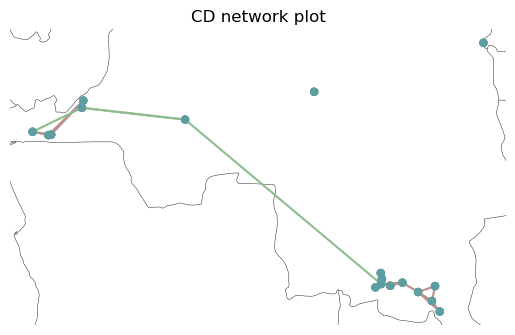

In [ ]:
network.plot(title=f"{country_code} network plot")

### Demand

In [23]:
demand_ember = get_demand_ember(ember_data, three_country_code, horizon)
pypsa_demand = get_demand_pypsa(network)

EIA_demand = get_data_EIA(EIA_demand_path, country_code, horizon)
EIA_demand = EIA_demand.iloc[0,1]

In [24]:
print(f"Demand from Ember: {demand_ember} \nDemand from PyPSA: {pypsa_demand} \nDemand from EIA: {EIA_demand}")

Demand from Ember: 0.64 
Demand from PyPSA: 74.8554 
Demand from EIA: 0.5131


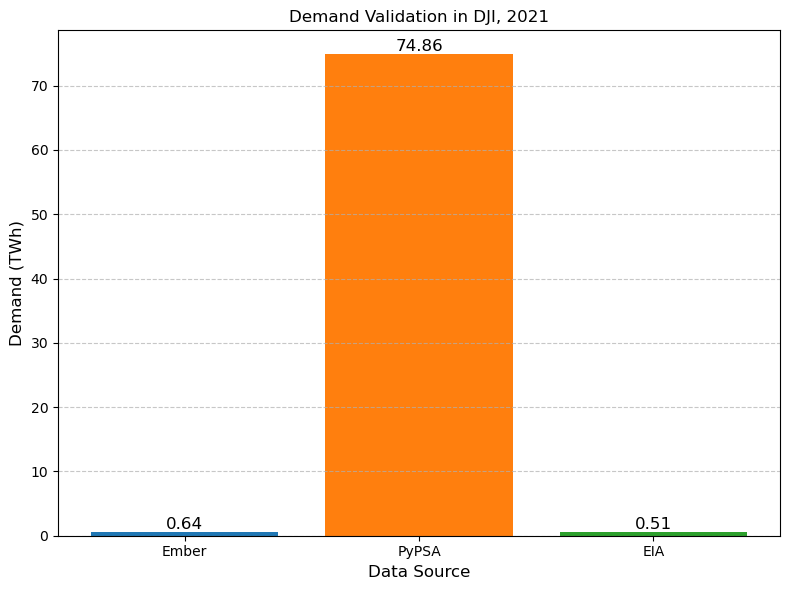

In [25]:
plt.figure(figsize=(8, 6))  # Set figure size
bars = plt.bar(["Ember", "PyPSA", "EIA"], [demand_ember, pypsa_demand, EIA_demand], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title(f"Demand Validation in {three_country_code}, {horizon}")
plt.ylabel("Demand (TWh)", fontsize=12)
plt.xlabel("Data Source", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/demand_validation_ember_{country_code}.png")
plt.show()

### Installed Capacity

In [26]:
installed_capacity_ember = get_installed_capacity_ember(ember_data, three_country_code, horizon)
pypsa_capacity = get_installed_capacity_pypsa(network)

In [27]:
EIA_inst_capacities = get_data_EIA(EIA_installed_capacities_path, country_code, horizon)
EIA_inst_capacities = preprocess_eia_data(EIA_inst_capacities)

In [28]:
installed_capacity_df = pd.concat([installed_capacity_ember, pypsa_capacity, EIA_inst_capacities], axis=1).fillna(0)
installed_capacity_df

,Ember data,PyPSA data,EIA Data
Biomass,0.00,0.0,0.0000
Fossil fuels,0.12,0.0,0.1300
Hydro,0.00,0.0,0.0000
Nuclear,0.00,0.0,0.0000
Solar,0.00,0.0,0.0004
Wind,0.02,0.0,0.0200
PHS,0.00,0.0,0.0000


In [29]:
installed_capacity_df.sum()

Ember data    0.1400
PyPSA data    0.0000
EIA Data      0.1504
dtype: float64

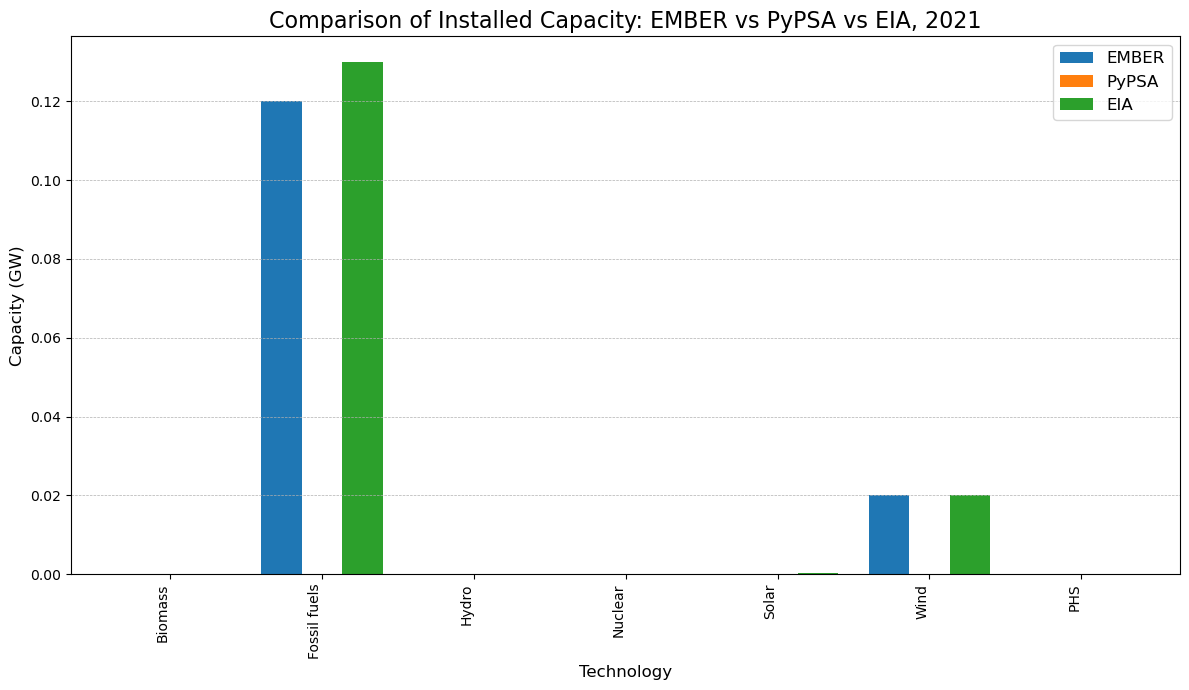

In [30]:
ax = installed_capacity_df.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Installed Capacity: EMBER vs PyPSA vs EIA, {horizon}", fontsize=16)
plt.xlabel("Technology", fontsize=12)
plt.ylabel("Capacity (GW)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/capacity_validation_ember_{country_code}.png")
plt.show()

### Generation

In [31]:
generation_data_ember = get_generation_capacity_ember(ember_data, three_country_code, horizon)
pypsa_generation = get_generation_capacity_pypsa(network)

In [32]:
EIA_generation = get_data_EIA(EIA_generation_path, country_code, horizon)
EIA_generation = preprocess_eia_data(EIA_generation)

In [33]:
generation_df = pd.concat([generation_data_ember, pypsa_generation, EIA_generation], axis=1).fillna(0)
generation_df

,Ember data,PyPSA data,EIA Data
Biomass,0.00,0.00000,0.0000
Fossil fuels,0.13,0.00000,0.1279
Hydro,0.00,0.00000,0.0000
Nuclear,0.00,0.00000,0.0000
Solar,0.00,77.39000,0.0012
Wind,0.00,0.93000,0.0000
Load shedding,0.00,0.22063,0.0000
PHS,0.00,0.00000,0.0000


In [34]:
generation_df.sum()

Ember data     0.13000
PyPSA data    78.54063
EIA Data       0.12910
dtype: float64

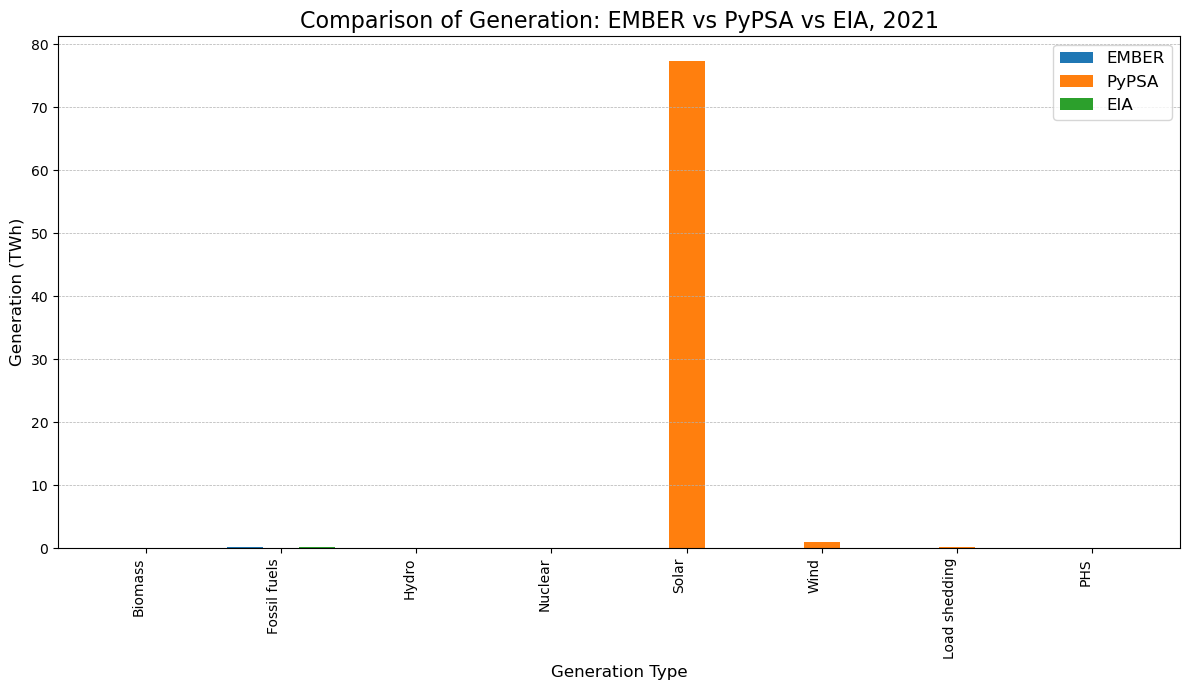

In [35]:
ax = generation_df.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Generation: EMBER vs PyPSA vs EIA, {horizon}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/generation_validation_ember_{country_code}.png")
plt.show()

#### More Details

##### Visualization

In [36]:
generation_data_ember_ = get_generation_capacity_ember_detail(ember_data, three_country_code, horizon)
EIA_generation_ = get_data_EIA(EIA_generation_path, country_code, horizon)
EIA_generation_ = preprocess_eia_data_generation(EIA_generation_)
pypsa_generation_ = get_generation_capacity_pypsa_detail(network)

In [37]:
generation_df_ = pd.concat([generation_data_ember_, pypsa_generation_, EIA_generation_], axis=1).fillna(0)
generation_df_

,Ember data,PyPSA data,EIA Data
Biomass,0.00,0.00000,0.0000
Coal,0.00,0.00000,0.0000
Hydro,0.00,0.00000,0.0000
Natural gas,0.00,0.00000,0.0000
Nuclear,0.00,0.00000,0.0000
Other Fossil,0.13,0.00000,0.0000
Solar,0.00,77.39000,0.0012
Wind,0.00,0.93000,0.0000
Load shedding,0.00,0.22063,0.0000
PHS,0.00,0.00000,0.0000


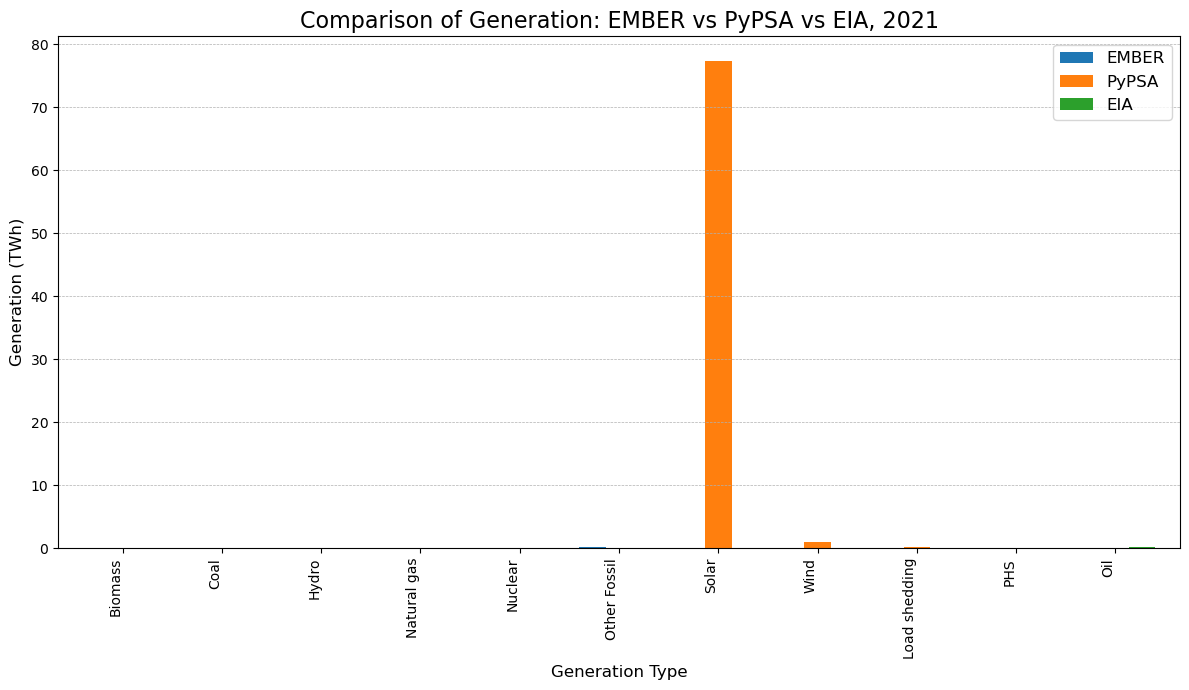

In [38]:
ax = generation_df_.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Generation: EMBER vs PyPSA vs EIA, {horizon}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/generation_validation_ember_{country_code}_detailed.png")
plt.show()